In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix

from sgpi import model
from sgpi.learner import SGRegressionLearner
import sqlalchemy as sa
from sqlalchemy import orm, func

from sgpi.plot import *

import pandas as pd
import pysgpp as sg; sg.omp_set_num_threads(4)

In [24]:
def get_results(session, id, base):
    if not isinstance(id, list):
        id = [id]
    results = session.query(model.Result).\
        join(model.RegularizationConfig).\
        join(model.Experiment).\
        filter(model.Experiment.experiment_id.between(id[0], id[-1])).\
        filter(model.RegularizationConfig.exponent_base == base).\
        order_by(model.RegularizationConfig.lambda_reg)    
    return results

def plot_grid_for_id(id, fig=None, ax=None):
    ses = model.make_session()

    results1 = get_results(ses, id, 1)
    results4 = get_results(ses, id, 4)

    lambda_1 = [res.regularization_config.lambda_reg for res in results1]
    mse_1 = [np.sqrt(res.validation_mse) for res in results1]

    lambda_4 = [res.regularization_config.lambda_reg for res in results4]
    mse_4 = [np.sqrt(res.validation_mse) for res in results4]    

    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    ax.semilogx(lambda_4, mse_4, c='red', label="Diagonal", linewidth=2.5)
    ax.semilogx(lambda_1, mse_1, c='gray', label="Identity", linewidth=2.5)
    ax.axhline(min(mse_1), c='black', linestyle='dashed', zorder=-1)
    ax.set_xlim(right=10e-2)
    ax.set_xlabel("Lambda")
    ax.set_ylabel("CV-RMSE")
    ax.legend()
    sns.despine(fig)
    return fig, ax

# Concrete

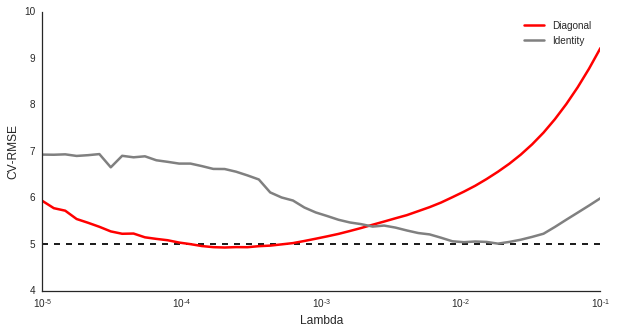

In [25]:
fig, ax = plot_grid_for_id(63) #l4, t=0
fig.savefig("../writing/thesis/figures/tikhonov_concrete_l4.pdf", bbox='tight', bbox_inches='tight')

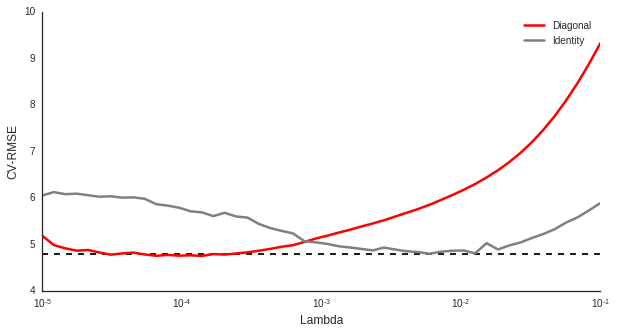

In [26]:
fig, ax = plot_grid_for_id(64) #l5, t=0.5
fig.savefig("../writing/thesis/figures/tikhonov_concrete_l5.pdf", bbox='tight', bbox_inches='tight')

# Power plant

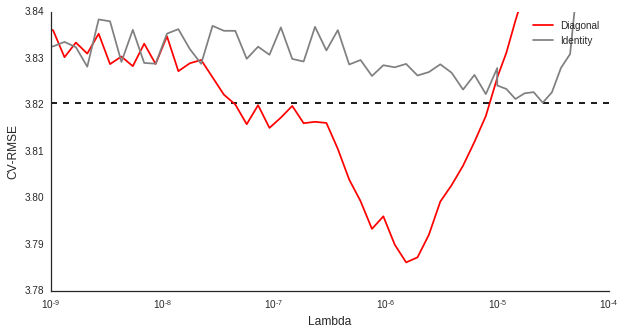

In [7]:
fig, ax = plot_grid_for_id([70,71])
ax.set_xlim(10e-10, 10e-5)
ax.set_ylim(3.78, 3.84)
fig.savefig("../writing/thesis/figures/tikhonov_power_plant_l5.pdf", bbox='tight', bbox_inches='tight')

In [7]:
session = model.make_session()
best = session.query(model.Result).\
        filter(model.Result.experiment_id == 71).\
        order_by(model.Result.validation_mse).first()

In [8]:
best.regularization_config.l1_ratio = 0.0
estimator = SGRegressionLearner(best.grid_config, best.regularization_config, best.solver_config, best.final_solver_config, best.adaptivity_config)

In [9]:
from sklearn.cross_validation import train_test_split

In [10]:
df = get_dataset('power_plant')

In [11]:
np.random.seed(42)
splits = [None] * 5
for i in  range(0, 5):
    splits[i] = df.reindex(np.random.permutation(df.index))

In [12]:
cv_results = []
for sp in splits:
    train, test = split(sp, test_size=0.5)
    X_train, y_train = get_xy(train)
    X_test, y_test = get_xy(test)
    estimator.fit(X_train, y_train)
    cv_results.append(np.sqrt(-estimator.score(X_test, y_test)))

KeyboardInterrupt: 

In [ ]:
np.sum(cv_results)/len(cv_results)

In [ ]:
cv_results

In [ ]:
np.sqrt(best.validation_mse)

In [ ]:
np.sqrt(best.test_mse)